In [107]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [108]:
example_ticker = 'AMZN'
data_start_date = '1900-01-01'

In [109]:
data = yf.Ticker(example_ticker).history(start=data_start_date)['Close']
data.index = data.index.tz_localize(None)

data

,Close
Date,
1997-05-15,0.097917
1997-05-16,0.086458
1997-05-19,0.085417
1997-05-20,0.081771
1997-05-21,0.071354
...,...
2024-11-05,199.500000
2024-11-06,207.089996
2024-11-07,210.050003


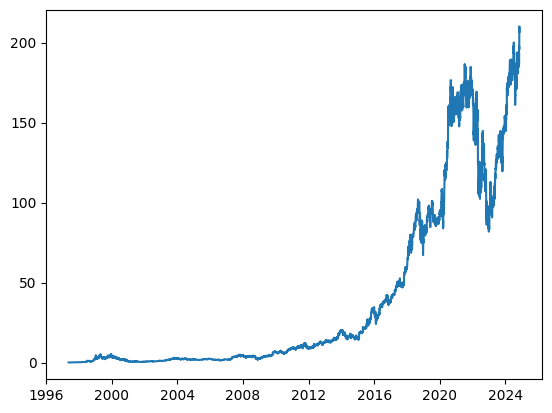

In [110]:
plt.plot(data.index, data)

In [158]:
import numpy as np
import pandas as pd
import datetime

def convert_to_windowed_data(df, first_date, last_date, n):

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = df.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset.to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date:target_date + datetime.timedelta(days=7)]

        if len(next_week) < 2:
            print(f'Error: Insufficient data to proceed from {target_date}')
            break

        next_date = next_week.index[1]

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df

def process_windowed_data(windowed_df):

    windowed_data_np = windowed_df.to_numpy()

    # print(windowed_data_np)

    dates = windowed_data_np[:, 0]
    matrix_pretarget = windowed_data_np[:, 1:-1]
    X = matrix_pretarget.reshape((len(dates), matrix_pretarget.shape[1], 1))

    target = windowed_data_np[:, -1]
    y = target

    return dates, X.astype(np.float32), y.astype(np.float32)

windowed_data = convert_to_windowed_data(data, datetime.datetime(2021, 3, 25), datetime.datetime(2024, 11, 8), 5)

# print(windowed_data)




In [159]:
dates, X, y = process_windowed_data(windowed_data)

dates.shape, X.shape, y.shape

((914,), (914, 5, 1), (914,))

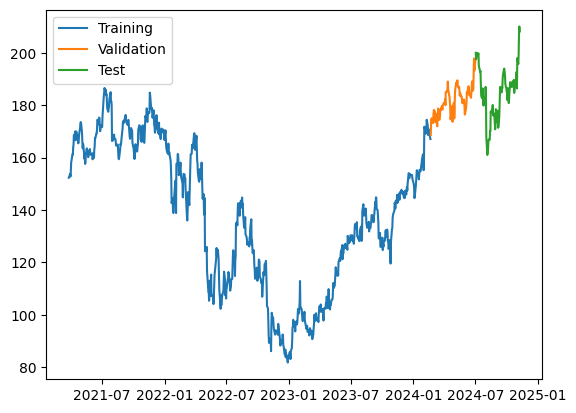

In [160]:
p_80 = int(len(dates) * 0.80)
p_90 = int(len(dates) * 0.90)

dates_train, X_train, y_train = dates[:p_80], X[:p_80], y[:p_80]
dates_validation, X_validation, y_validation = dates[p_80:p_90], X[p_80:p_90], y[p_80:p_90]
dates_test, X_test, y_test = dates[p_90:], X[p_90:], y[p_90:]

plt.plot(dates_train, y_train, label='Training')
plt.plot(dates_validation, y_validation, label='Validation')
plt.plot(dates_test, y_test, label='Test')
plt.legend()

In [161]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [162]:

# using RNN since data is clearly ordered over time
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', metrics=['mean_absolute_error'], optimizer=Adam(learning_rate=0.001))

model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=105)

Epoch 1/105
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 19471.4434 - mean_absolute_error: 136.6606 - val_loss: 31637.1875 - val_mean_absolute_error: 177.7807
Epoch 2/105
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17753.3340 - mean_absolute_error: 130.3893 - val_loss: 28394.7363 - val_mean_absolute_error: 168.4137
Epoch 3/105
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 14235.1709 - mean_absolute_error: 115.9066 - val_loss: 18254.9004 - val_mean_absolute_error: 134.9935
Epoch 4/105
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6408.7505 - mean_absolute_error: 72.3240 - val_loss: 1896.4116 - val_mean_absolute_error: 43.1677
Epoch 5/105
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 794.1342 - mean_absolute_error: 23.1868 - val_loss: 1932.5577 - val_mean_absolute_error: 43.6045
Epoch 6/105
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 765.4769 - mean_absolute_error: 23.9745 - val_loss: 2031.6051 - val_mean_absolute_error: 44.7514
Epoch 7/105
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms

In [163]:
train_predictions = model.predict(X_train).flatten()
validation_predictions = model.predict(X_validation).flatten()
test_predictions = model.predict(X_test).flatten()

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


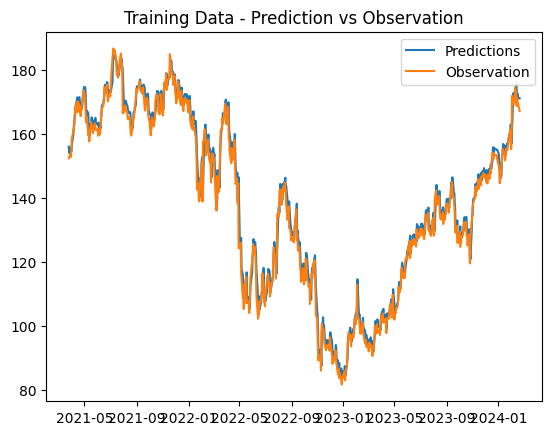

In [164]:
plt.plot(dates_train, train_predictions, label='Predictions')
plt.plot(dates_train, y_train, label='Observation')
plt.title('Training Data - Prediction vs Observation')
plt.legend()

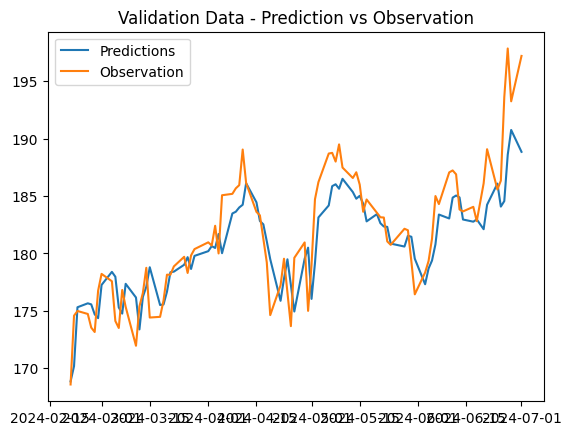

In [165]:
plt.plot(dates_validation, validation_predictions, label='Predictions')
plt.plot(dates_validation, y_validation, label='Observation')
plt.title('Validation Data - Prediction vs Observation')
plt.legend()

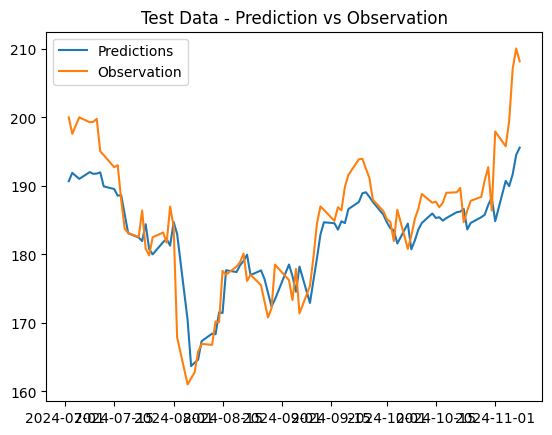

In [166]:
plt.plot(dates_test, test_predictions, label='Predictions')
plt.plot(dates_test, y_test, label='Observation')
plt.title('Test Data - Prediction vs Observation')
plt.legend()

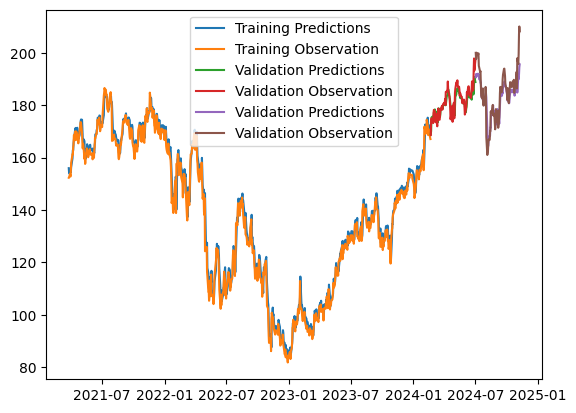

In [167]:
plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observation')
plt.plot(dates_validation, validation_predictions, label='Validation Predictions')
plt.plot(dates_validation, y_validation, label='Validation Observation')
plt.plot(dates_test, test_predictions, label='Validation Predictions')
plt.plot(dates_test, y_test, label='Validation Observation')
plt.legend()
